Dataset shape: (3000, 14)
   Flight ID    Airline  Flight_Distance Origin_Airport Destination_Airport  \
0    7319483  Airline D              475      Airport 3           Airport 2   
1    4791965  Airline E              538      Airport 5           Airport 4   
2    2991718  Airline C              565      Airport 1           Airport 2   
3    4220106  Airline E              658      Airport 5           Airport 3   
4    2263008  Airline E              566      Airport 2           Airport 2   

   Scheduled_Departure_Time  Day_of_Week  Month Airplane_Type  Weather_Score  \
0                         4            6      1        Type C       0.225122   
1                        12            1      6        Type B       0.060346   
2                        17            3      9        Type C       0.093920   
3                         1            1      8        Type B       0.656750   
4                        19            7     12        Type E       0.505211   

   Previous_Flight

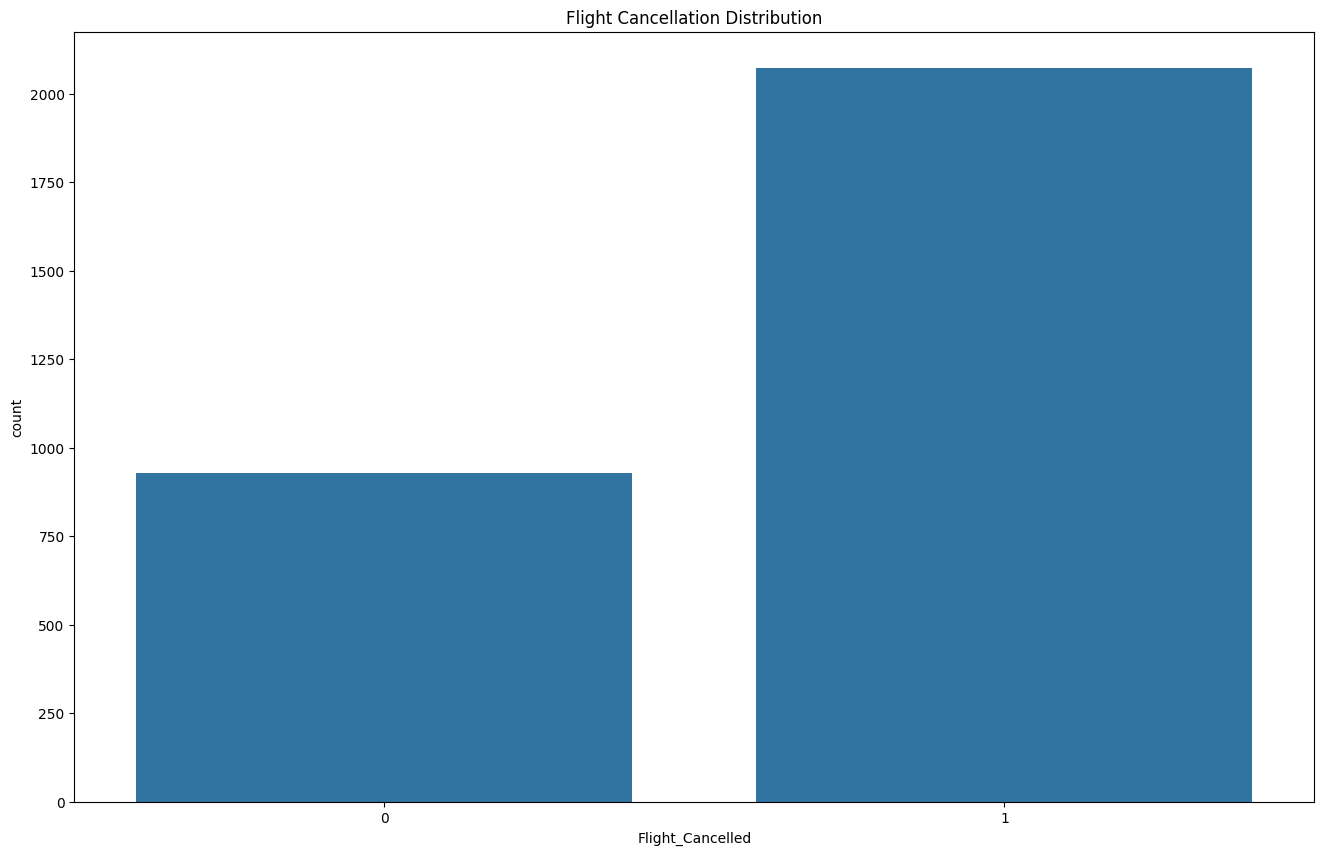

<Figure size 1600x1200 with 0 Axes>

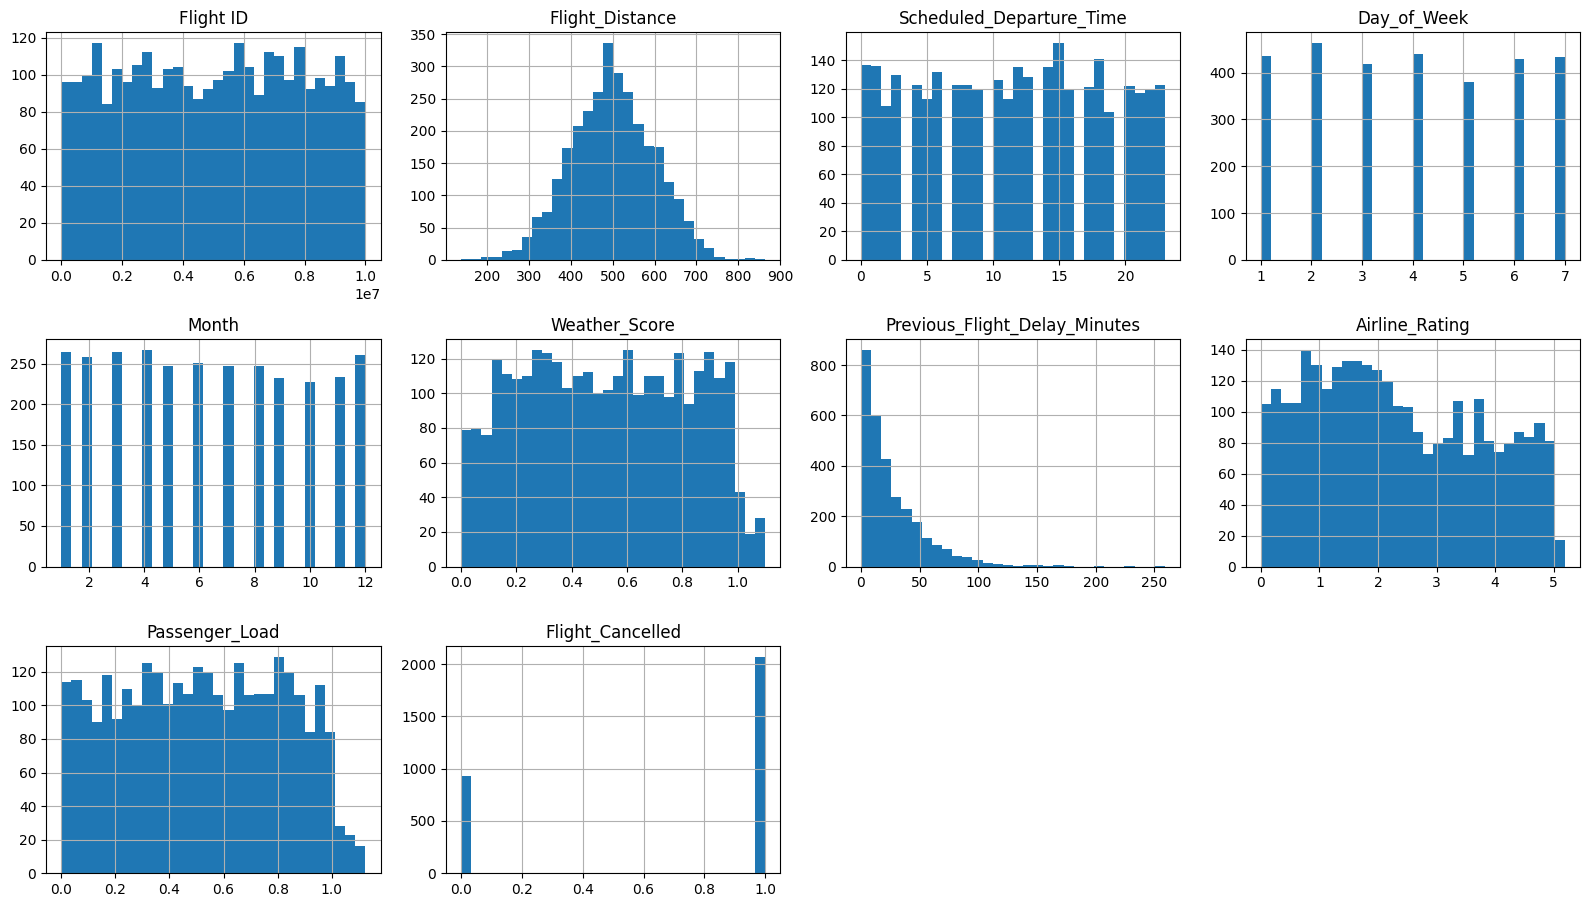

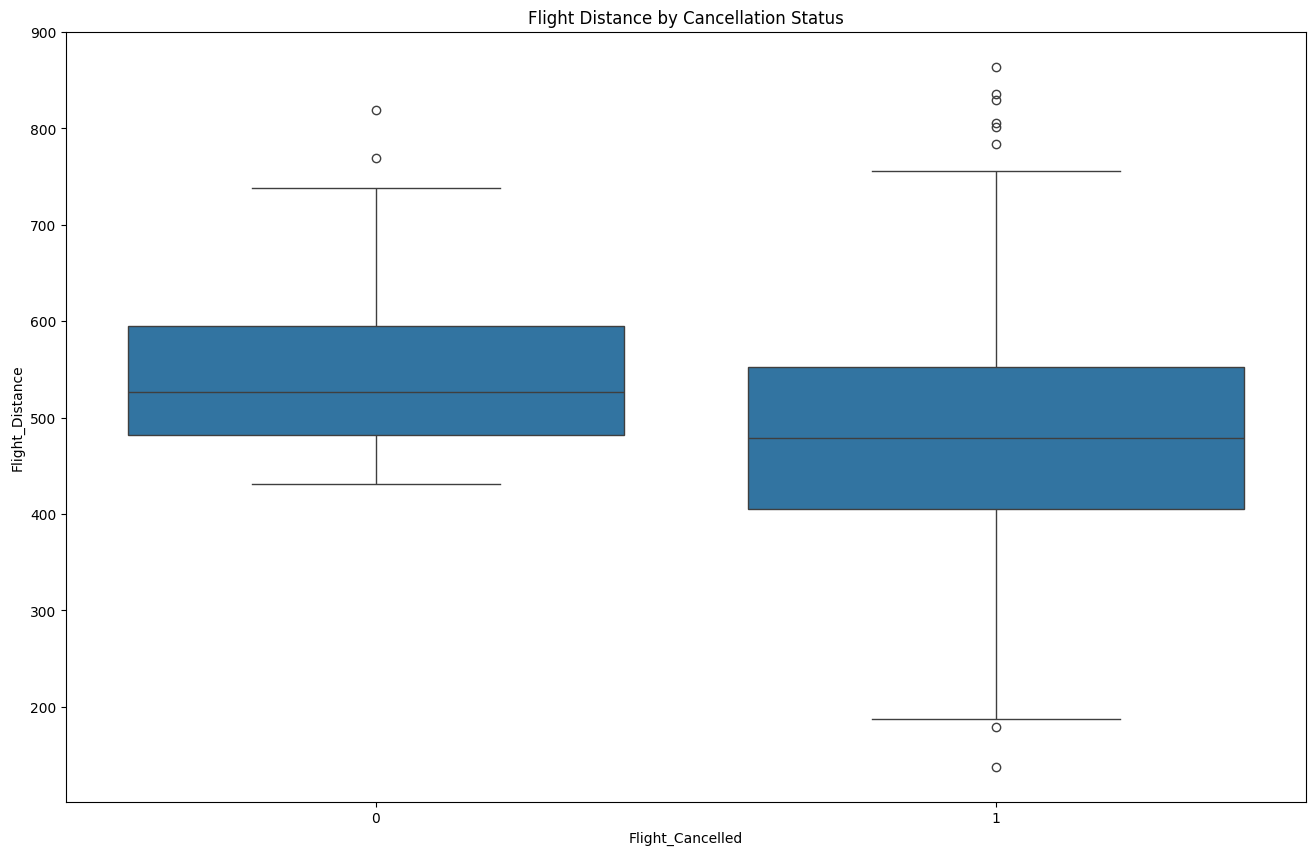

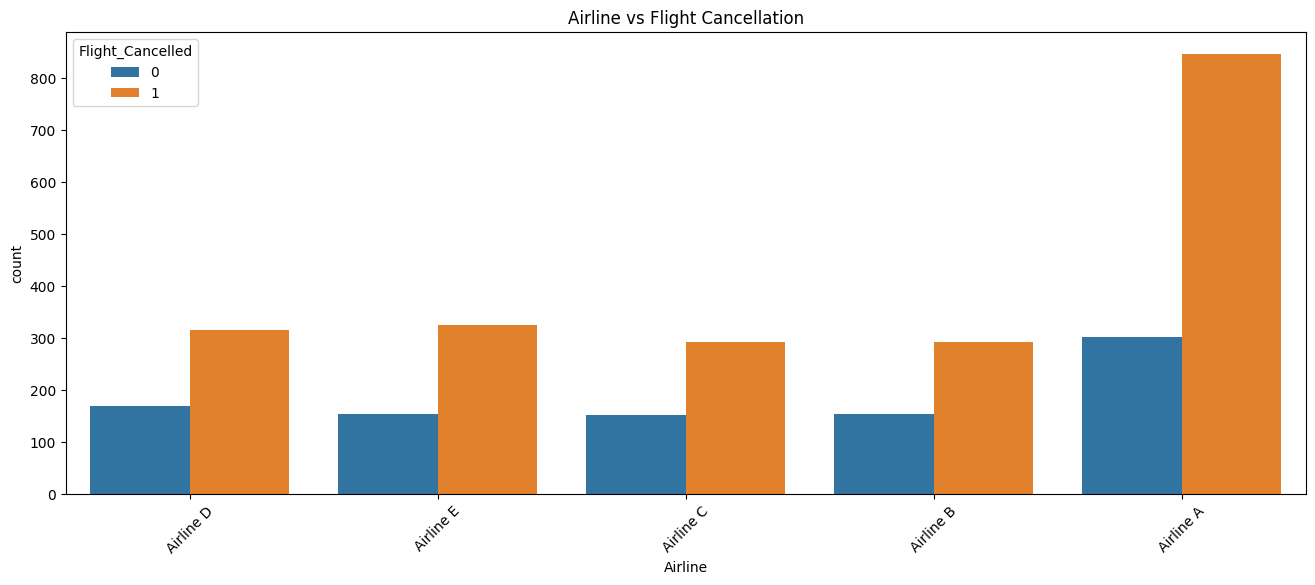

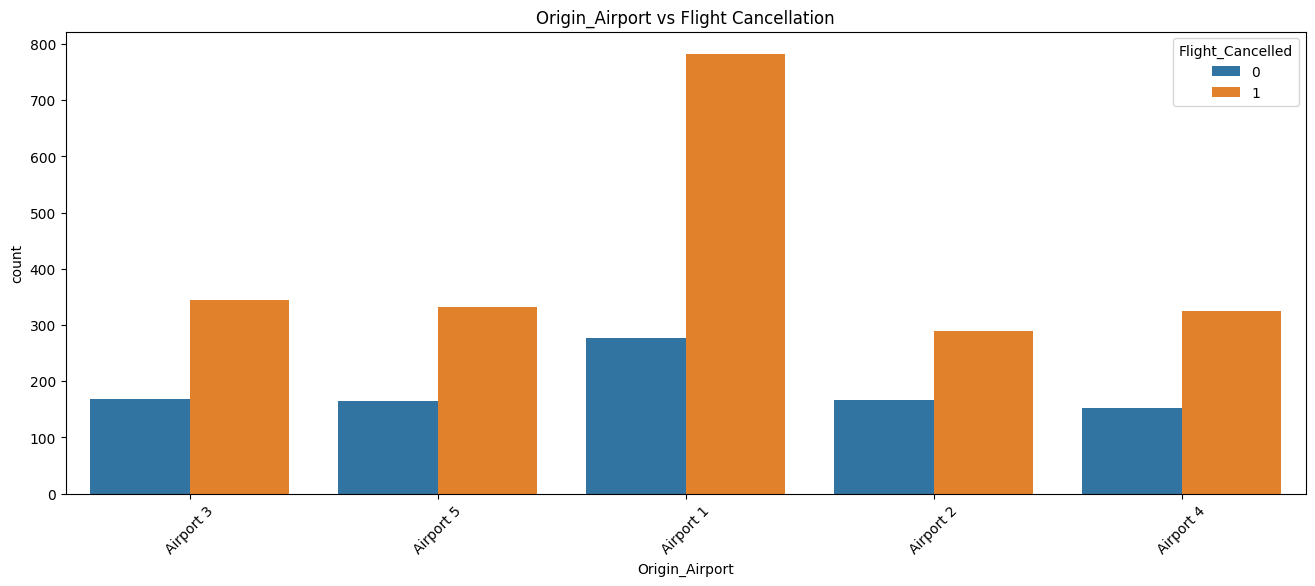

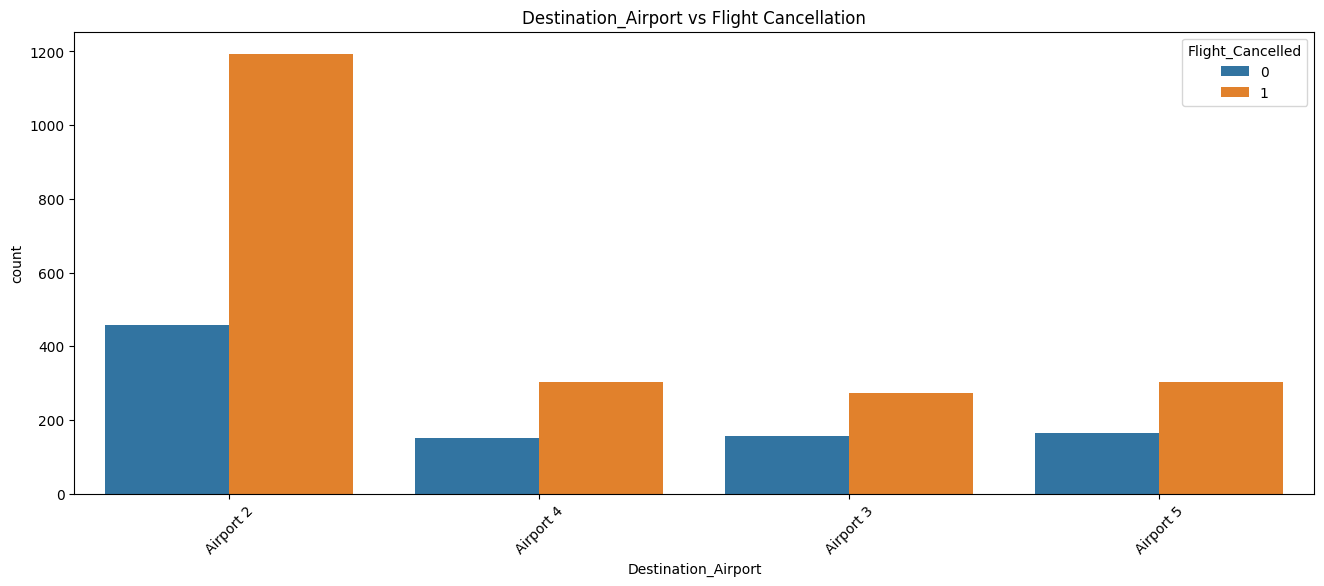

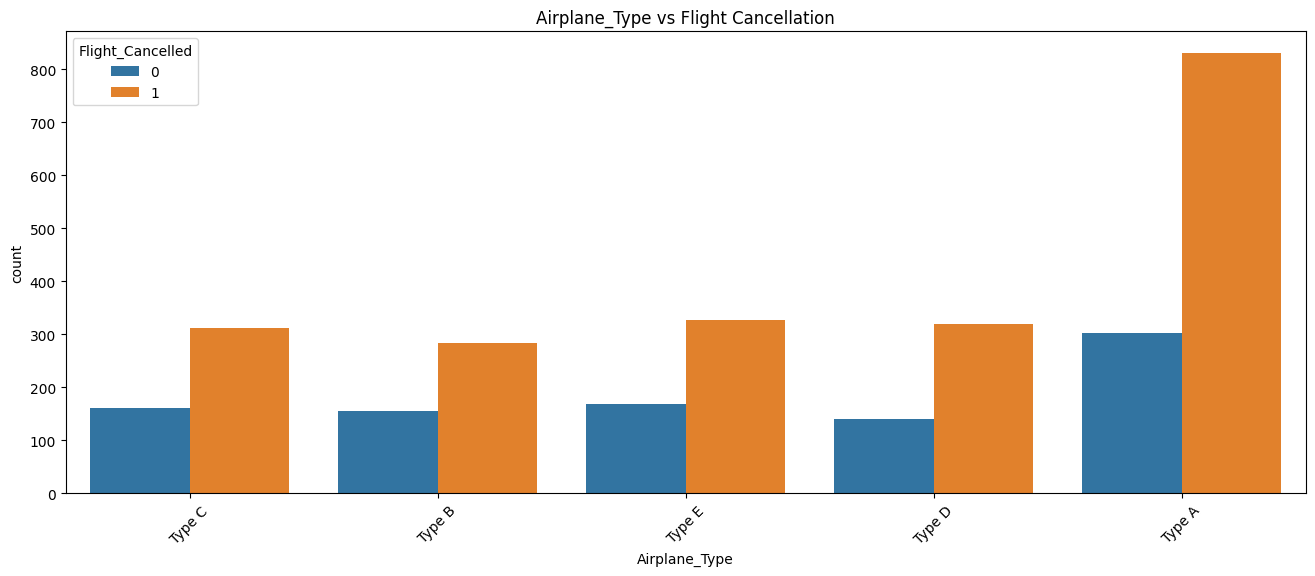

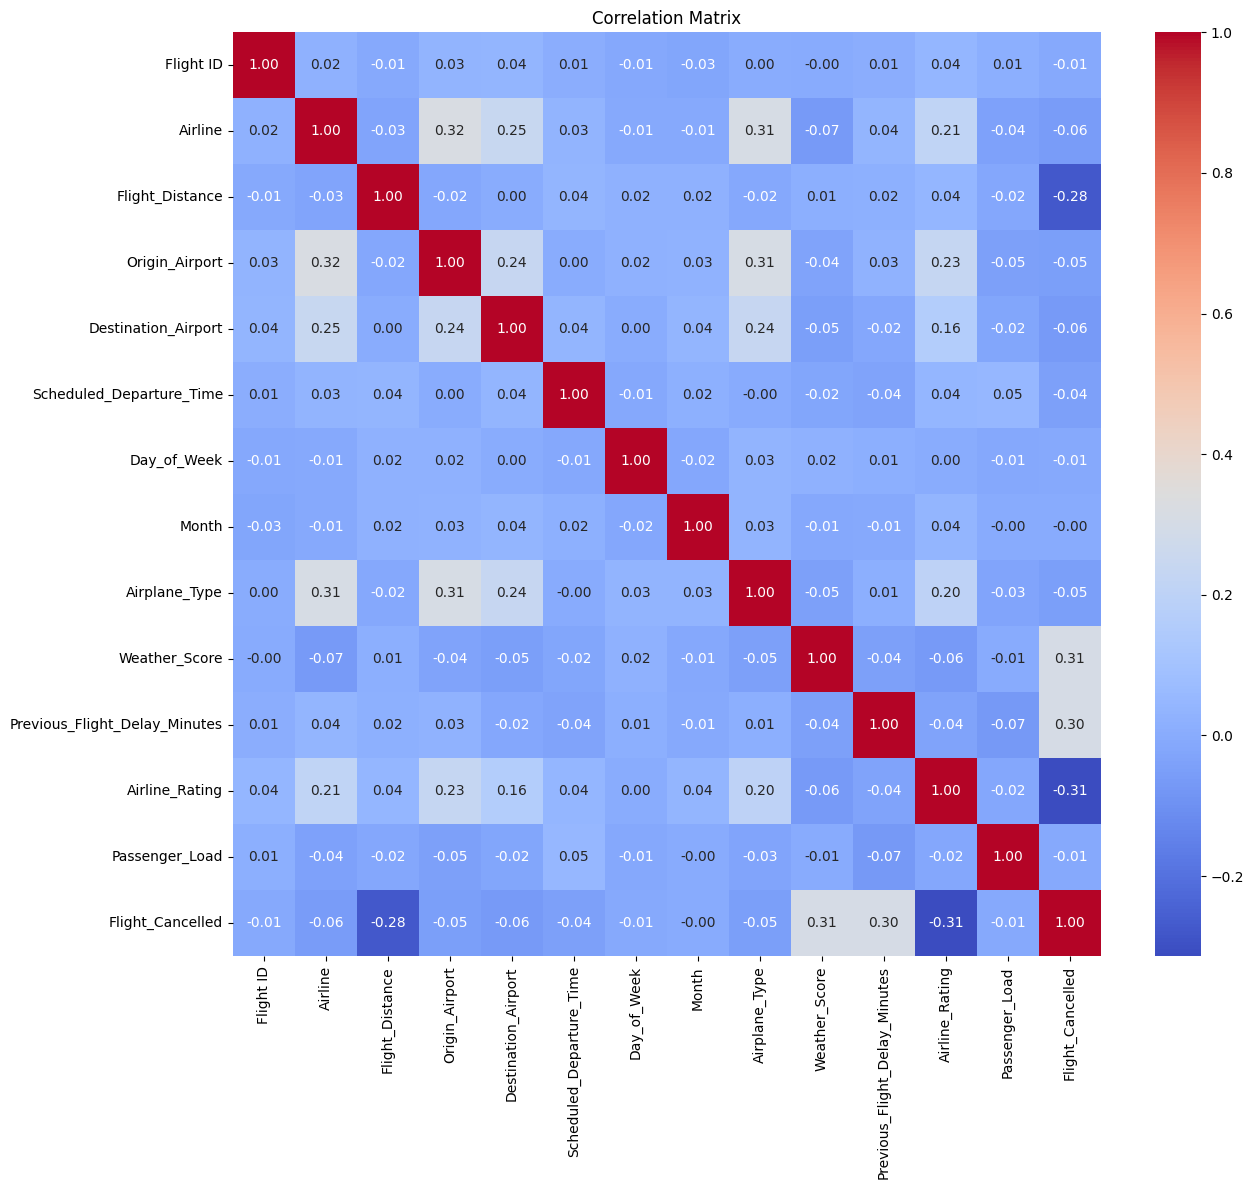

Logistic Regression Accuracy: 0.8156 ROC-AUC: 0.8797
Random Forest Accuracy: 0.9811 ROC-AUC: 0.9891
Support Vector Machine Accuracy: 0.8867 ROC-AUC: 0.9546


In [6]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, accuracy_score, roc_auc_score
from sklearn.svm import SVC

df = pd.read_csv('flight_data.csv')

print("Dataset shape:", df.shape)
print(df.head())

print("\nDescriptive Statistics:\n", df.describe())

plt.figure(figsize=(16, 10))
sns.countplot(data=df, x='Flight_Cancelled')
plt.title('Flight Cancellation Distribution')
plt.show()

plt.figure(figsize=(16, 12))
df.select_dtypes(include=['int64', 'float64']).hist(bins=30, figsize=(16, 12), layout=(4, 4))
plt.tight_layout()
plt.show()

plt.figure(figsize=(16,10))
sns.boxplot(x='Flight_Cancelled', y='Flight_Distance', data=df)
plt.title('Flight Distance by Cancellation Status')
plt.show()

categorical_features = ['Airline', 'Origin_Airport', 'Destination_Airport', 'Airplane_Type']

for col in categorical_features:
    plt.figure(figsize=(16, 6))
    sns.countplot(data=df, x=col, hue='Flight_Cancelled')
    plt.title(f'{col} vs Flight Cancellation')
    plt.xticks(rotation=45)
    plt.show()

le = LabelEncoder()
for col in categorical_features:
    df[col] = le.fit_transform(df[col])

# Now it's safe to compute the correlation matrix
plt.figure(figsize=(14, 12))
corr = df.corr(numeric_only=True)
sns.heatmap(corr, annot=True, fmt='.2f', cmap='coolwarm')
plt.title('Correlation Matrix')
plt.show()

# Prepare features and target
columns_to_drop = ['Flight_Cancelled']
if 'Flight_ID' in df.columns:
    columns_to_drop.append('Flight_ID')

X = df.drop(columns=columns_to_drop)
y = df['Flight_Cancelled']

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.3, random_state=42, stratify=y)

models = {
    'Logistic Regression': LogisticRegression(max_iter=500),
    'Random Forest': RandomForestClassifier(n_estimators=200, random_state=42),
    'Support Vector Machine': SVC(probability=True, kernel='rbf', random_state=42)
}

results = []
for name, model in models.items():
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    y_prob = model.predict_proba(X_test)[:, 1] if hasattr(model, "predict_proba") else model.decision_function(X_test)
    accuracy = accuracy_score(y_test, y_pred)
    roc_auc = roc_auc_score(y_test, y_prob)
    results.append({
        'Model': name,
        'Accuracy': accuracy,
        'ROC_AUC': roc_auc,
        'Classification Report': classification_report(y_test, y_pred, output_dict=True)
    })
    print(f"{name} Accuracy: {accuracy:.4f} ROC-AUC: {roc_auc:.4f}")

models_summary = pd.DataFrame({
    'Model': [r['Model'] for r in results],
    'Accuracy': [r['Accuracy'] for r in results],
    'ROC_AUC': [r['ROC_AUC'] for r in results]
})

models_summary.to_csv('flight_cancellation_model_performance_comparison.csv', index=False)
df.to_csv('flight_cancellation_processed_dataset.csv', index=False)
